In [ ]:
!pip3 install -U datatops==0.2.2 gensim==4.3.1 matplotlib==3.7.1 matplotlib-inline==0.1.3 numpy==1.22.4 requests==2.28.2 requests-oauthlib==1.3.0 scikit-learn==1.2.2 vibecheck==0.0.3 > /dev/null 2>&1

# Text Embeddings: Preface

* **Authors**: Jordan Matelsky
* **Reviewers**: Lyle Ungar, Konrad Kording

Today we are going to study word embeddings, a technique that allows us to represent text as numerical inputs or outputs to a neural network. **Note that you don't need to have a GPU for today's tutorial.**

> * This notebook will use a new feedback mechanism to get vibe-checks throughout the notebook; please do feel encouraged to click the feedback buttons to submit anonymous feedback! This will not count toward your grade.
> * In general, Jupyter notebooks should follow good code-style practices, and all the imports should go at the top. But because much of this code might be useful to you in the future, we will leave cells with imports in them throughout the notebook so that it is easy to copy and paste to reuse this code. For more information on notebook best practices, see [here](https://gist.github.com/j6k4m8/864fb5a8a2257237169a48b6bd6a307e).

Video available at https://youtube.com/watch?v=vzsDA8qazW8


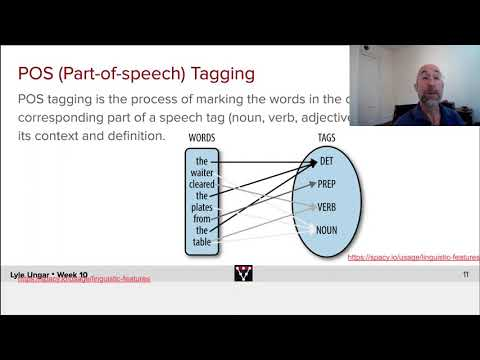

In [1]:
# @title Video : NLP  Introduction
from IPython.display import YouTubeVideo

video = YouTubeVideo(id="vzsDA8qazW8", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


In [ ]:
# @title Feedback setup (run this cell)

# Feedback with Datatops
from vibecheck import DatatopsContentReviewContainer
from datatops import Datatops

feedback_dtid = "62a48t3w"
feedback_name = "cis522_feedback"
quiz_dtid = "lxx8szk1"
quiz_name = "cis522_quiz"
dt_url = "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab/"

# Instantiate the Datatops client
dt = Datatops(dt_url)
quizdt = dt.get_project(quiz_name, user_key=quiz_dtid)


In [ ]:
my_pennkey = "" #@param {type:"string"}
my_pod = "" #@param {type:"string"}
my_email = "" #@param {type:"string"}

In [ ]:
# Download the corpus. For this notebook, we're going to use the copy of Moby Dick that's available on Project Gutenberg.
import requests

RAW_CORPUS = "".join([
    char.lower() for char in requests.get("https://www.gutenberg.org/files/2701/2701-0.txt").text
    if char.isalpha() or char in " \n\t"
]).split()

# Text Embeddings

In the course so far, we've discussed how to represent images as vectors. This has usually been pretty easy; we've just considered each pixel as its own dimension, and imagined an image as simply a folded-up long vector. We've also discussed low-dimension representations of larger vectors, like when we used PCA or VAEs to reduce the dimensionality of our images to a smaller latent space.

Today we'll discuss how to do the same thing for text. We're going to implement a few different ways to embed text, and we'll see the advantages and disadvantages of each. 

Each embedding will follow this [protocol](https://en.wikipedia.org/wiki/Protocol_(object-oriented_programming)):

In [ ]:
from typing import List, Protocol

import numpy as np

class WordEmbedder(Protocol):

    def fit(self, sentence_corpus: List[List[str]], **kwargs) -> None:
        ...

    def transform(self, sentence: List[str]) -> np.ndarray:
        ...
        

Let's first think about the most naive thing we could do; a one-hot encoding!

A one-hot encoding is a vector of length $V$, where $V$ is the size of the vocabulary. The vector is all zeros, except for a single 1, which is in the position of the word's index in the vocabulary. Let's build a simple example:

```python
>>> VOCAB = ['the', 'cat', 'ate', 'fish', 'dog']
```

Now, let's encode the sentence "the cat ate the fish":

```
vocab: the cat ate fish dog
THE    1   0   0   0    0   
CAT    0   1   0   0    0
ATE    0   0   1   0    0
THE    1   0   0   0    0
FISH   0   0   0   1    0
```


In [ ]:
class OneHotEncoder(WordEmbedder):

    _vocab: List[str]

    def fit(self, sentence_corpus: List[List[str]]) -> None:
        """
        Create a vocabulary from the corpus.

        Arguments:
            sentence_corpus: A list of sentences, where each sentence is a list of words.

        """
        self._vocab = list(set(word for sentence in sentence_corpus for word in sentence))
        

    def transform(self, sentence: List[str]) -> np.ndarray:
        """
        Encode a sentence as a one-hot vector.

        Arguments:
            sentence: A list of words.

        Returns:
            A one-hot vector for the sentence.

        """
        return np.array([
            [int(word.lower() == vocab_word) for vocab_word in self._vocab]
            for word in sentence
        ])

In [ ]:
ohe_embedder = OneHotEncoder()
ohe_embedder.fit([RAW_CORPUS])
for vec in ohe_embedder.transform("This fellow wants to beat up a whale".split()):
    unit_location = np.where(vec == 1)[0][0]
    print(f"[{unit_location} zeros... 1 ...a lot more zeros]")

This is a very easy way to represent text, but it has a few problems. First, it's very sparse. We have a lot of zeros in our vectors, and we're wasting a lot of space. Second, it's not very informative. We don't really know anything about the relationships between words. For example, there's no way for us to indicate that "cat" and "dog" are similar words, or that "fish" (noun) and "ate" (verb) are dissimilar. In a "good" embedding, we'd like to be able to capture these relationships and say that two words have a similar meaning if they're close together in the embedding space.

Right now, all of our words are equally far apart, because each word is orthogonal to every other word!

## Quiz!

**We could fix the sparsity problem by using PCA to drop the vectors into a smaller space. Why wouldn't that be a useful embedding for our purposes?**

In [ ]:
why_ohe_pca_isnt_useful = "" #@param {type:"string"}

Video available at https://youtube.com/watch?v=ufqGdQcwa5A


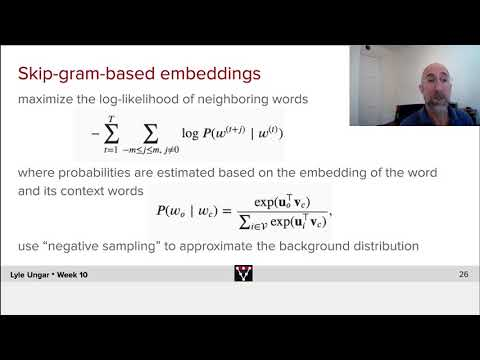

In [2]:
#@title Video : Embeddings
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ufqGdQcwa5A", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

## Attempt 2: Using the word's surroundings in the corpus

Here's another approach: We could look at a word's surroundings, and clump words with similar surroundings into the same part of the embedding space. For example, if we had a dataset that included the sentences,

```
...
The cat ate the snack
The dog ate the snack
...
```

...then it would be reasonable to imagine that "cat" and "dog" have something in common (they're snack-eaters!), and so they should embed — at least along some dimensions — close to each other. 

How can we formalize this fill-in-the-blanks embedding?

In [ ]:
import numpy as np
from typing import List


class CBOWEmbedder:
    def __init__(self, embedding_dim: int):
        self.embedding_dim = embedding_dim

    def fit(
        self,
        sentences: List[List[str]],
        window_size: int = 2,
        learning_rate: float = 0.001,
        epochs: int = 10,
    ) -> None:
        """
        Train the model using SGD.

        Arguments:
            sentences: A list of sentences, where each sentence is a list of words.
            window_size: The number of words to the left and right of the center word to consider.
            learning_rate: The learning rate for the gradient descent.
            epochs: The number of epochs to train for.

        """
        # Create a vocabulary, which is a sorted list of unique words:
        self.vocab = list(
            sorted(set(word for sentence in sentences for word in sentence))
        )
        vocab_size = len(self.vocab)

        # Make it easy to convert between words and indices:
        self.word_to_index = {word: index for index, word in enumerate(self.vocab)}
        self.index_to_word = {index: word for index, word in enumerate(self.vocab)}

        # Create the context windows:
        windows = []
        for sentence in sentences:
            for center_word_index, center_word in enumerate(sentence):
                for offset in range(-window_size, window_size + 1):
                    context_word_index = center_word_index + offset
                    if (
                        context_word_index < 0
                        or context_word_index >= len(sentence)
                        or offset == 0
                    ):
                        continue
                    context_word = sentence[context_word_index]
                    windows.append(
                        (
                            self.word_to_index[center_word],
                            self.word_to_index[context_word],
                        )
                    )

        self.embeddings = np.random.rand(vocab_size, self.embedding_dim)
        for epoch in range(epochs):
            loss = 0
            for center_word, context_word in windows:
                # Embed the center and context words:
                center_embed = ...
                context_embed = ...

                # Compute the dot product and the sigmoid output. This is the
                # probability that the context word is the correct output:
                dot_product = ...
                sigmoid_output = ...

                # Compute the gradients, which are the difference between the
                # sigmoid output and 1:
                gradient_center_embed = (sigmoid_output - 1) * context_embed
                gradient_context_embed = (sigmoid_output - 1) * center_embed

                # Update the embeddings using the gradients and the learning 
                # rate that we set earlier:
                self.embeddings[center_word] -= learning_rate * gradient_center_embed
                self.embeddings[context_word] -= learning_rate * gradient_context_embed

                loss += -np.log(sigmoid_output)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss}", end="\r")

    def transform(self, word: str) -> np.ndarray:
        """
        Get the embedding for a word.

        Arguments:
            word: The word to get the embedding for (a string)

        Returns:
            The embedding for the word as a numpy array of shape (embedding_dim,).

        """
        word = word.lower().strip()
        ...
        raise NotImplementedError("Implement this method!")


In [ ]:
# Test out the embedder.
# TODO: Play with these hyperparameters to see how they affect the embeddings;
#       you can also try changing the corpus at the top of the notebook.
sg_embedder = CBOWEmbedder(embedding_dim=...)
sg_embedder.fit([RAW_CORPUS], epochs=5, window_size=2)

In [ ]:
sentence = (
    "This book is a story about a man who wants to beat up a whale so he goes out in a boat and it takes a long time"
).split()
embedding = [sg_embedder.transform(w) for w in sentence]

In [ ]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

embedding_2d = PCA(n_components=2).fit_transform(embedding)


plt.figure(figsize=(10, 10))
plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c="red"
)
for i, word in enumerate(sentence):
    plt.annotate(word, (embedding_2d[i, 0], embedding_2d[i, 1]))
plt.show()



In [ ]:
# Closest words in the sentence:

def closest_words(embedder, word, n=5):
    word_embedding = embedder.transform(word)
    distances = np.linalg.norm(embedder.embeddings - word_embedding, axis=1)
    closest_indices = np.argsort(distances)[:n]
    return [embedder.index_to_word[i] for i in closest_indices]


closest_words(sg_embedder, "he")

In [ ]:
#@title .
DatatopsContentReviewContainer(
    "",
    "W9D1_Custom_Word2Vec",
    {
        "url": dt_url,
        "name": feedback_name,
        "user_key": feedback_dtid,
    }
).render()

Alright — let's be real; no one ever trains their own word embeddings like this on some tiny dataset. Like most reasonable people in machine learning, we're going to use a pre-trained embedding. (Remember in the stable diffusion notebook — even the authors of latent diffusion used off-the-shelf embeddings!)

One of the most common pre-trained embeddings is called [GloVe](https://nlp.stanford.edu/projects/glove/). Let's explore some pre-trained embeddings below.

### Further Reading for this Section

- [Word2Vec Tutorial](https://www.tensorflow.org/tutorials/text/word2vec)
- [Word2Vec vs GloVe](https://machinelearninginterview.com/topics/natural-language-processing/what-is-the-difference-between-word2vec-and-glove/)

In [ ]:
# Import GloVe embeddings from gensim
import gensim.downloader as api

glove_model = api.load('glove-twitter-25')

One fascinating byproduct of word embeddings is that we can do all sorts of interesting "word arithmetic." For example, now "distances" between words is well-defined:

In [ ]:
# TODO: Try out some other words and see what the embeddings look like!

words = {
    "fish": glove_model["fish"],
    "mermaid": glove_model["mermaid"],
    "shark": glove_model["shark"],
    "boy": glove_model["boy"],
    "girl": glove_model["girl"],
    "prince": glove_model["prince"],
    "princess": glove_model["princess"],
    "knight": glove_model["knight"],
}

glove_vecs_2d = PCA(n_components=2).fit_transform(
    list(words.values())
)


In [ ]:
print("Distance between fish and boy:", np.linalg.norm(words["fish"] - words["boy"]))
print("Distance between fish and shark:", np.linalg.norm(words["fish"] - words["shark"]))

In other words, more conceptually similar words are closer together in the embedding space. Even more interesting,

In [ ]:
plt.figure(figsize=(4, 4), dpi=150)
for i, word in enumerate(words):
    plt.scatter(
        glove_vecs_2d[i, 0],
        glove_vecs_2d[i, 1],
        c="red"
    )
    plt.annotate(word, (glove_vecs_2d[i, 0], glove_vecs_2d[i, 1]))


(WARNING: we are of course looking at some very low dimensional shadows of the true embedding space! Caution is advised!)

To go from the "prince" to "princess" vector, we go up and to the right. To go from "boy" to "girl," we do a similar transformation. And to go from "knight" to "mermaid..." Alright, well maybe a "fantasy-novel traditionally-male-flavored chracter" and a "fantasy-novel traditionally-female-flavored chracter"...? 

Let's try some other math:

In [ ]:
glove_model.most_similar("fish")

What is the word for "ethanol" added to the concept of fun?

In [ ]:
# Get the closest word to this new vector:
glove_model.similar_by_vector((glove_model["ethanol"] + glove_model["fun"]), topn=1)

Crabs are to the sea as `_____` are to the desert?

(Analogy format: crab:sea :: ?:desert)

In [ ]:
# Analogies with GloVe embeddings:
crab = glove_model["crab"]
seas = glove_model["seas"]
desert = glove_model["desert"]

# crab:seas :: desert:?
glove_model.similar_by_vector(crab - seas + desert, topn=1)

...uh.

Not quite.

Turns out, the famous "King - Man + Woman = Queen" analogy — which was commonly used to show how word vectorization has intuitive superpowers — doesn't really work either:

In [ ]:
# Analogies with GloVe embeddings:
king = glove_model["king"]
man = glove_model["man"]
woman = glove_model["woman"]

# king:man :: woman:?
glove_model.similar_by_vector(king - man + woman, topn=1)

For more reading, check out [this great blog post](https://blog.esciencecenter.nl/king-man-woman-king-9a7fd2935a85). And If you really want to dive into the science of word embeddings some more, you can explore the differences between the algorithm we wrote today — the CBOW model, where we use $n$ future and past words to predict the current word — and the [Skip-gram model](https://paperswithcode.com/method/skip-gram-word2vec), where we use the current word to predict its context words.

But nowhere are the failings of these context-free embeddings more plain than when you find homonyms:

In [ ]:
colors = ["red", "green", "blue", "purple", "pink", "brown", "black", "gray", "yellow"]
color_vecs = [glove_model[col] for col in colors]
fruits = [
    "apple",
    "banana",
    "pear",
    "grape",
    "strawberry",
    "blueberry",
    "raspberry",
    "cherry",
]
fruit_vecs = [glove_model[frt] for frt in fruits]

orange = glove_model["orange"]

glove_pca = PCA(n_components=2)
glove_pca.fit(np.concatenate([color_vecs, fruit_vecs, [orange]]))

colors_2d = glove_pca.transform([glove_model[color] for color in colors])
fruits_2d = glove_pca.transform([glove_model[fruit] for fruit in fruits])
orange_2d = glove_pca.transform([orange])


plt.figure(figsize=(4, 4), dpi=150)
plt.scatter(colors_2d[:, 0], colors_2d[:, 1], c="red", s=5)
plt.scatter(fruits_2d[:, 0], fruits_2d[:, 1], c="green", s=5)
plt.scatter(orange_2d[:, 0], orange_2d[:, 1], c="orange")


Poor orange :( It doesn't know if it's a color or a fruit!

And that makes sense; in our current model, a word can only have one embedding. So if we have a word with multiple meanings, like "orange", we wind up _smearing_ its meanings into one vector.

What we really want is a context-dependent embedding. That is, not only do we want to create the embedding for a word based upon its context; we also want to embed each _instance_ of a word in a target dataset based upon the words we find around it. In our ideal embedding, if we see the sentence "I love to drink orange juice", the vector for `orange` should be different than the vector for `orange` in the sentence "I don't believe in orange rhinoceroses".

In [ ]:
#@title .
DatatopsContentReviewContainer(
    "",
    "W9D1_Homonyms",
    {
        "url": dt_url,
        "name": feedback_name,
        "user_key": feedback_dtid,
    }
).render()

## Thought Experiments!

**Try asking your favorite large language model (e.g., https://chat.openai.com or Bing Chat) a question that includes a made-up word. For example, "What is the most snooooglylooking puppy?" Is the model able to recover the meaning of the word? Clearly the model has to embed your question and its words somehow... In a sentence or two, how would you build such an embedding algorithm?**

In [ ]:
how_fabricated_embeddings = "" #@param {type:"string"}

**So far, all of our embedding techniques have embedded single words at a time, even though we've trained on full sentences or even full stories. In a sentence or two, how would you write a sentence-embedding algorithm? What properties would you want this embedding system to have? (For example, in the word-embedding case, we wanted similar-meaning words to be close; or we wanted words that could fill the same sentence blank to be close together...)** 

Feel free to play around with the code in this notebook; some example code is provided in the cell below!

In [ ]:
sentence_vectorization = "" #@param {type:"string"}

In [ ]:
class SentenceEmbedder:
    def __init__(self, word_embedder: WordEmbedder):
        self._embedder = word_embedder

    def transform(self, sentence):
        words = [word.lower() for word in sentence.split()]
        word_embeddings = [self._embedder.transform(word)[0] for word in words]
        # TODO: combine the word embeddings into a single sentence embedding
        raise NotImplementedError("Implement the `combined_embedding` line below.")
        combined_embedding = ...
        return combined_embedding


emb = OneHotEncoder()  # or CBOWEmbedder()
emb.fit([RAW_CORPUS])
semb = SentenceEmbedder(emb)
sentences = [
    "where should we have dinner",
    "what is your favorite food",
    "what is your favorite color",
    "i am eating dinner over here",
    "a red apple is a fruit",
    "a green apple is a fruit",
    "a red apple is not a dinner",
]
sentence_embeddings_2d = PCA(2).fit_transform(
    [semb.transform(sentence) for sentence in sentences]
)

plt.figure(figsize=(4, 4), dpi=150)
for i, sentence in enumerate(sentences):
    plt.scatter(sentence_embeddings_2d[i, 0], sentence_embeddings_2d[i, 1], c="red")
    plt.annotate(sentence, (sentence_embeddings_2d[i, 0], sentence_embeddings_2d[i, 1]))


## Submission

Run the cell below to submit your answers.

In [ ]:
# @title Submit your quiz answers (run this cell to submit)

quizdt.store(
    dict(
        notebook="W9D1_Text_Embeddings",
        my_pennkey=my_pennkey,
        my_pod=my_pod,
        my_email=my_email,
        why_ohe_pca_isnt_useful=why_ohe_pca_isnt_useful,
        how_fabricated_embeddings=how_fabricated_embeddings,
        sentence_vectorization=sentence_vectorization
    )
)